In [34]:
import time
import random
import json
import os
import subprocess
import datetime as dt
import pandas as pd
import numpy as np
from collections import Counter #outlier detect
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential 
from keras.layers import Dense, Activation, Embedding, Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline 

train_set = './data/train.csv'
test_set = './data/test.csv'
submission_set = './data/gender_submission.csv'

In [2]:
df = pd.read_csv(train_set)
test = pd.read_csv(test_set)
subs = pd.read_csv(submission_set)
df.head(5) # Survived = label (=bool). Is the passenger survived ?! (1 = Yes)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The shape of the train set : (891, 12) . 
There are 0.38% of people which have survived.

There are 0 items on 891 which are null in the Pclass column. 
There are 0 items on 891 which are null in the Name column. 
There are 0 items on 891 which are null in the Sex column. 
There are 177 items on 891 which are null in the Age column. 
There are 0 items on 891 which are null in the SibSp column. 
There are 0 items on 891 which are null in the Parch column. 
There are 0 items on 891 which are null in the Ticket column. 
There are 0 items on 891 which are null in the Fare column. 
There are 687 items on 891 which are null in the Cabin column. 
There are 2 items on 891 which are null in the Embarked column. 


<AxesSubplot:>

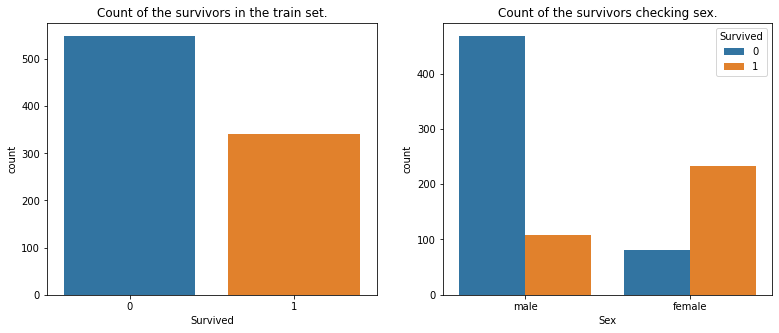

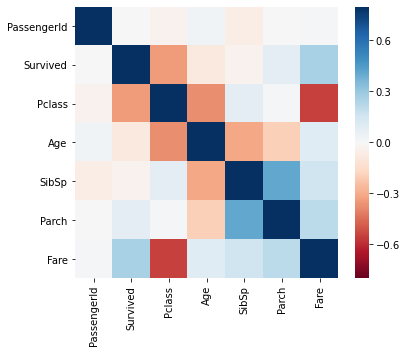

In [3]:
# Shape and ratio
shape = df.shape
shape_test = test.shape
ratio_survived = df.Survived.value_counts()[1] / (df.Survived.value_counts()[1] + df.Survived.value_counts()[0]) 
print("The shape of the train set : {} . ".format(shape))
print("There are {}% of people which have survived.\n".format(round(ratio_survived, 2)))

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.countplot(x=df.Survived).set_title("Count of the survivors in the train set.")
plt.subplot(122)
sns.countplot(x=df.Sex, hue=df.Survived).set_title("Count of the survivors checking sex.")

# Number of items nan in the train set.
no_Pclass = df.isnull().sum().Pclass
no_Name = df.isnull().sum().Name
no_Sex = df.isnull().sum().Sex
no_Age = df.isnull().sum().Age
no_SibSp = df.isnull().sum().SibSp
no_Parch = df.isnull().sum().Parch
no_Ticket = df.isnull().sum().Ticket
no_Fare = df.isnull().sum().Fare
no_Cabin = df.isnull().sum().Cabin
no_Embarked = df.isnull().sum().Embarked

print("There are {} items on {} which are null in the Pclass column. ".format(no_Pclass, shape[0]))
print("There are {} items on {} which are null in the Name column. ".format(no_Name, shape[0]))
print("There are {} items on {} which are null in the Sex column. ".format(no_Sex, shape[0]))
print("There are {} items on {} which are null in the Age column. ".format(no_Age, shape[0]))
print("There are {} items on {} which are null in the SibSp column. ".format(no_SibSp, shape[0]))
print("There are {} items on {} which are null in the Parch column. ".format(no_Parch, shape[0]))
print("There are {} items on {} which are null in the Ticket column. ".format(no_Ticket, shape[0]))
print("There are {} items on {} which are null in the Fare column. ".format(no_Fare, shape[0]))
print("There are {} items on {} which are null in the Cabin column. ".format(no_Cabin, shape[0]))
print("There are {} items on {} which are null in the Embarked column. ".format(no_Embarked, shape[0]))
 
    
# Arrange the data
X = df.drop(['Survived', 'PassengerId', 'Cabin'], axis=1) # I do not use the 'Ticket' column.
test = test.drop(['Cabin'], axis=1) # I do not use the 'Ticket' column.
Y = df.Survived.values # Transforming my output as np.array


# Draw the correlation map between the columns in the train set.
plt.figure(figsize=(13,5))
df_corr = df.corr()
plt.subplot(121)
sns.heatmap(df_corr, cmap='RdBu', vmax=0.8, vmin=-0.8)

In [4]:
# Outlier detection : https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(X, 2, ["Age","SibSp","Parch","Fare"])
print("There are {} outliers to drop.".format(len(Outliers_to_drop)))
# Drop outliers
X.drop(Outliers_to_drop, axis=0) # .reset_index(drop=True)

There are 10 outliers to drop.


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q
6,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S
9,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C


In [5]:
# Fill the nan values of the Age column with the mean value.
print("Moyenne d'age en première classe = {} ans.".format(np.mean(X[X.Pclass==1].Age)))
print("Moyenne d'age en seconde classe = {} ans.".format(np.mean(X[X.Pclass==2].Age)))
print("Moyenne d'age en troisième classe = {} ans.".format(np.mean(X[X.Pclass==3].Age)))
X.loc[(X.Age.isnull()) & (X.Pclass==1), "Age"] = np.mean(X[X.Pclass==1].Age)
X.loc[(X.Age.isnull()) & (X.Pclass==2), "Age"] = np.mean(X[X.Pclass==2].Age)
X.loc[(X.Age.isnull()) & (X.Pclass==3), 'Age'] = np.mean(X[X.Pclass==3].Age)

test.loc[(test.Age.isnull()) & (test.Pclass==1), "Age"] = np.mean(X[X.Pclass==1].Age)
test.loc[(test.Age.isnull()) & (test.Pclass==2), "Age"] = np.mean(X[X.Pclass==2].Age)
test.loc[(test.Age.isnull()) & (test.Pclass==3), "Age"] = np.mean(X[X.Pclass==3].Age)

print("There are {} items on {} which are null in the Age column. ".format(len(X[X.Age.isnull()]), shape[0]))

# Shaping Age
X.loc[ (X.Age <= 16), 'Age']= 0
X.loc[ ((X.Age > 16) & (X.Age <= 32)), 'Age']= 1
X.loc[ ((X.Age > 32) & (X.Age <= 48)), 'Age']= 2
X.loc[ (X.Age > 48), 'Age']= 3

test.loc[ (test.Age <= 16), 'Age']= 0
test.loc[ ((test.Age > 16) & (test.Age <= 32)), 'Age']= 1
test.loc[ ((test.Age > 32) & (test.Age <= 48)), 'Age']= 2
test.loc[ (test.Age > 48), 'Age']= 3

Moyenne d'age en première classe = 38.233440860215055 ans.
Moyenne d'age en seconde classe = 29.87763005780347 ans.
Moyenne d'age en troisième classe = 25.14061971830986 ans.
There are 0 items on 891 which are null in the Age column. 


In [6]:
print("There are {} items on {} which are null in the Fare column - test. ".format(len(test[test.Fare.isnull()]), shape[0]))
test.loc[(test.Fare.isnull()), "Fare"] = np.mean(test.Fare)
print("There are {} items on {} which are null in the Fare column - test. ".format(len(test[test.Fare.isnull()]), shape[0]))

There are 1 items on 891 which are null in the Fare column - test. 
There are 0 items on 891 which are null in the Fare column - test. 


Text(0.5, 1.0, 'Test set')

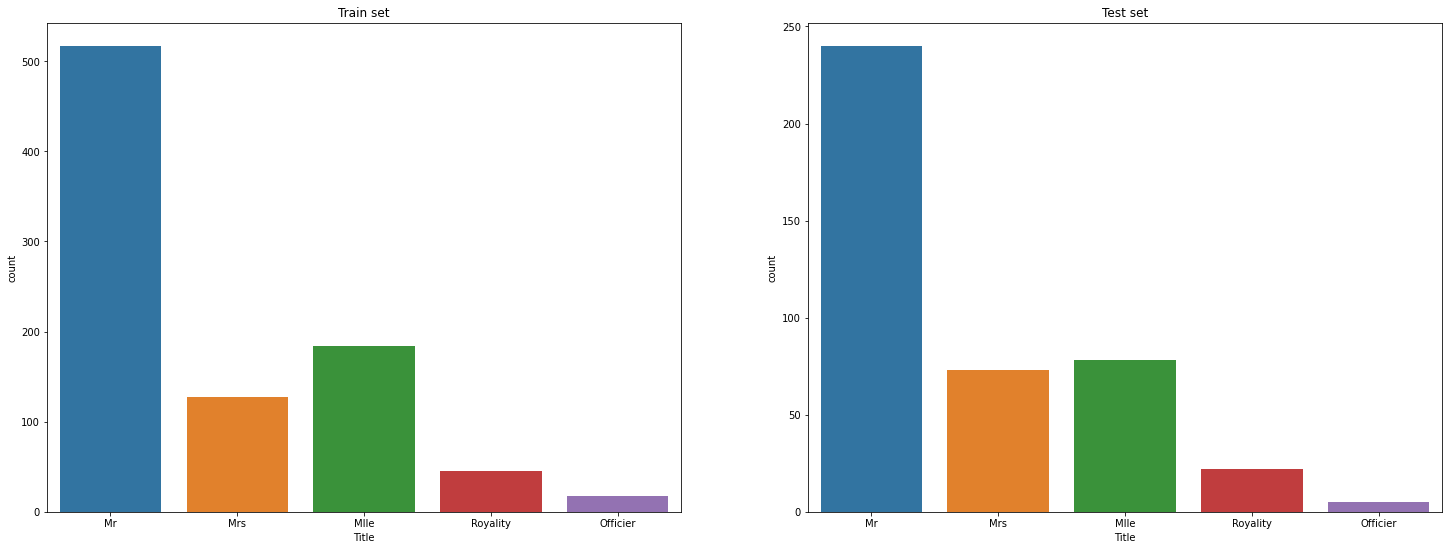

In [7]:
# Shaping the 'Title' column using the name of the passenger.
X["Title"] = X["Name"].str.extract('([A-Za-z]+)\.',expand=False)
test["Title"] = test["Name"].str.extract('([A-Za-z]+)\.', expand=False)

X.loc[(X.Title == 'Ms'), 'Title'] = 'Mrs'
X.loc[(X.Title == 'Mme'), 'Title'] = 'Mrs'
X.loc[(X.Title == 'Miss'), 'Title'] = 'Mlle'
X.loc[(X.Title == 'Capt'), 'Title'] = 'Officier'
X.loc[(X.Title == 'Col'), 'Title'] = 'Officier'
X.loc[(X.Title == 'Dr'), 'Title'] = 'Officier'
X.loc[(X.Title == 'Rev'), 'Title'] = 'Officier'
X.loc[(X.Title == 'Major'), 'Title'] = 'Officier'
X.loc[(X.Title == 'Master'), 'Title'] = 'Royality'
X.loc[(X.Title == 'Don'), 'Title'] = 'Royality'
X.loc[(X.Title == 'Lady'), 'Title'] = 'Royality'
X.loc[(X.Title == 'Sir'), 'Title'] = 'Royality'
X.loc[(X.Title == 'Countess'), 'Title'] = 'Royality'
X.loc[(X.Title == 'Jonkheer'), 'Title'] = 'Royality'

test.loc[(test.Title == 'Ms'), 'Title'] = 'Mrs'
test.loc[(test.Title == 'Mme'), 'Title'] = 'Mrs'
test.loc[(test.Title == 'Miss'), 'Title'] = 'Mlle'
test.loc[(test.Title == 'Capt'), 'Title'] = 'Officier'
test.loc[(test.Title == 'Col'), 'Title'] = 'Officier'
test.loc[(test.Title == 'Dr'), 'Title'] = 'Officier'
test.loc[(test.Title == 'Rev'), 'Title'] = 'Officier'
test.loc[(test.Title == 'Major'), 'Title'] = 'Officier'
test.loc[(test.Title == 'Master'), 'Title'] = 'Royality'
test.loc[(test.Title == 'Don'), 'Title'] = 'Royality'
test.loc[(test.Title == 'Lady'), 'Title'] = 'Royality'
test.loc[(test.Title == 'Sir'), 'Title'] = 'Royality'
test.loc[(test.Title == 'Countess'), 'Title'] = 'Royality'
test.loc[(test.Title == 'Jonkheer'), 'Title'] = 'Royality'
test.loc[(test.Title == 'Dona'), 'Title'] = 'Royality'

plt.figure(figsize=(25,9))
plt.subplot(121)
sns.countplot(x=X.Title).set_title('Train set')
plt.subplot(122)
sns.countplot(x=test.Title).set_title('Test set')

In [8]:
X['familySize'] = X.SibSp + X.Parch + 1
X['isAlone'] = 1
X['isAlone'].loc[X['familySize'] > 1] = 0
test['familySize'] = test.SibSp + test.Parch + 1
test['isAlone'] = 1 
test['isAlone'].loc[test['familySize'] > 1] = 0

D:\Logiciel\Progra\Anaconda\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
X['fareBin'] = pd.qcut(X['Fare'], q=4, labels=[0, 1, 2, 3])
test['fareBin'] = pd.qcut(test['Fare'], q=4, labels=[0, 1, 2, 3])

In [10]:
print("There are {} items on {} which are null in the Embarked column - train. ".format(len(X[X.Embarked.isnull()]), shape[0]))
X.Embarked = X.Embarked.fillna(X.Embarked.mode()[0])
print("There are {} items on {} which are null in the Embarked column - train. ".format(len(X[X.Embarked.isnull()]), shape[0]))

There are 2 items on 891 which are null in the Embarked column - train. 
There are 0 items on 891 which are null in the Embarked column - train. 


In [11]:
# Shaping the Ticket column.
temp = X.Ticket.str.split(expand=True)
for index, item in enumerate(temp.values) :
    if(item[1] == None) :
        X.loc[X.index[index], 'Ticket1'] = None
        X.loc[X.index[index], 'Ticket2'] = item[0]
    else :
        X.loc[X.index[index], 'Ticket1'] = item[0]
        X.loc[X.index[index], 'Ticket2'] = item[1]

In [12]:
# Shaping the Family name.
temp = X.Name.str.split(',', expand=True)
X['familyName'] = temp[0]

In [13]:
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,familySize,isAlone,fareBin,Ticket1,Ticket2,familyName
0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,S,Mr,2,0,0,A/5,21171,Braund
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C,Mrs,2,0,3,PC,17599,Cumings
2,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,7.9250,S,Mlle,1,1,1,STON/O2.,3101282,Heikkinen
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,S,Mrs,2,0,3,None,113803,Futrelle
4,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,S,Mr,1,1,1,None,373450,Allen


Text(0.5, 1.0, 'People who survived by class.')

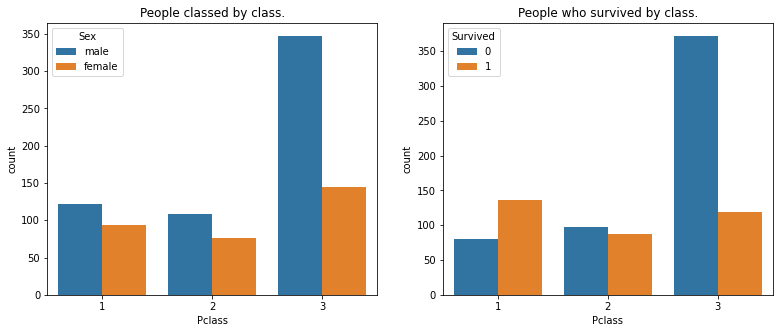

In [14]:
# Age without 177 items -> mean
plt.figure(figsize=(13,5))
plt.subplot(121)
sns.countplot(x=X.Pclass, hue=X.Sex).set_title("People classed by class.")
plt.subplot(122)
sns.countplot(x=df.Pclass, hue=df.Survived).set_title("People who survived by class.")

Text(0.5, 1.0, 'Parent(s) and Child(ren) aboard.')

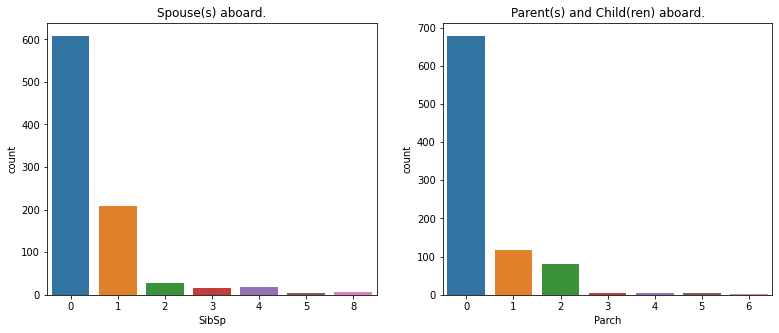

In [15]:
plt.figure(figsize= (13,5))
plt.subplot(121)
sns.countplot(x=X.SibSp).set_title("Spouse(s) aboard.")
plt.subplot(122)
sns.countplot(x=X.Parch).set_title("Parent(s) and Child(ren) aboard.")

Text(0.5, 1.0, 'Which embarcation site survived the most.')

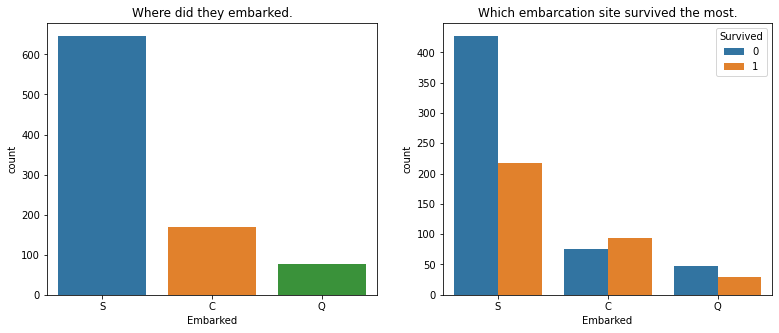

In [16]:
plt.figure(figsize= (13,5))
plt.subplot(121)
sns.countplot(x=X.Embarked).set_title("Where did they embarked.")
plt.subplot(122)
sns.countplot(x=df.Embarked, hue=df.Survived).set_title("Which embarcation site survived the most.")

D:\Logiciel\Progra\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
D:\Logiciel\Progra\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
D:\Logiciel\Progra\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
D:\Logiciel\Progra\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


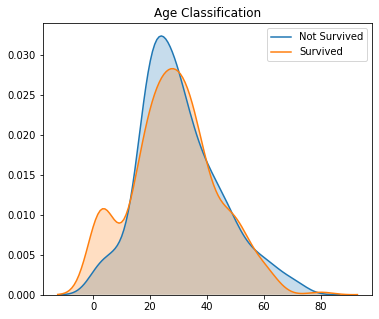

In [17]:
plt.figure(figsize=(13, 5))
plt.subplot(121)
ax = sns.kdeplot(df[df.Survived==0].Age, shade=True)
ax = sns.kdeplot(df[df.Survived==1].Age, shade=True)
ax.set_title("Age Classification")
ax.legend(["Not Survived", "Survived"])

In [18]:
# Verification of my pre-processing.
print("Train set : ")
print("There are {} items on {} which are null in the Sex column. ".format(X.isnull().sum().Sex, shape[0]))
print("There are {} items on {} which are null in the Embarked column. ".format(X.isnull().sum().Embarked, shape[0]))
print("There are {} items on {} which are null in the Parch column. ".format(X.isnull().sum().Parch, shape[0]))
print("There are {} items on {} which are null in the SibSp column. ".format(X.isnull().sum().SibSp, shape[0]))
print("There are {} items on {} which are null in the Pclass column. ".format(X.isnull().sum().Pclass, shape[0]))
print("There are {} items on {} which are null in the Title column. ".format(X.isnull().sum().Title, shape[0]))
print("There are {} items on {} which are null in the Fare column. ".format(X.isnull().sum().Fare, shape[0]))
print("There are {} items on {} which are null in the Age column. ".format(X.isnull().sum().Age, shape[0]))

print("\nTest set :")
print("There are {} items on {} which are null in the Sex column. ".format(test.isnull().sum().Sex, shape_test[0]))
print("There are {} items on {} which are null in the Embarked column. ".format(test.isnull().sum().Embarked, shape_test[0]))
print("There are {} items on {} which are null in the Parch column. ".format(test.isnull().sum().Parch, shape_test[0]))
print("There are {} items on {} which are null in the SibSp column. ".format(test.isnull().sum().SibSp, shape_test[0]))
print("There are {} items on {} which are null in the Pclass column. ".format(test.isnull().sum().Pclass, shape_test[0]))
print("There are {} items on {} which are null in the Title column. ".format(test.isnull().sum().Title, shape_test[0]))
print("There are {} items on {} which are null in the Fare column. ".format(test.isnull().sum().Fare, shape_test[0]))
print("There are {} items on {} which are null in the Age column. ".format(test.isnull().sum().Age, shape_test[0]))

Train set : 
There are 0 items on 891 which are null in the Sex column. 
There are 0 items on 891 which are null in the Embarked column. 
There are 0 items on 891 which are null in the Parch column. 
There are 0 items on 891 which are null in the SibSp column. 
There are 0 items on 891 which are null in the Pclass column. 
There are 0 items on 891 which are null in the Title column. 
There are 0 items on 891 which are null in the Fare column. 
There are 0 items on 891 which are null in the Age column. 

Test set :
There are 0 items on 418 which are null in the Sex column. 
There are 0 items on 418 which are null in the Embarked column. 
There are 0 items on 418 which are null in the Parch column. 
There are 0 items on 418 which are null in the SibSp column. 
There are 0 items on 418 which are null in the Pclass column. 
There are 0 items on 418 which are null in the Title column. 
There are 0 items on 418 which are null in the Fare column. 
There are 0 items on 418 which are null in th

In [19]:
# Shaping the inputs. 
def transformDatas (datas) :
    le = preprocessing.LabelEncoder()
    le.fit(datas)
    return le.transform(datas)

X.Embarked = str(X.Embarked)
test.Embarked = str(test.Embarked)

Sex = transformDatas(X.Sex)
Embarked = transformDatas(X.Embarked)
Parch = transformDatas(X.Parch)
SibSp = transformDatas(X.SibSp)
Pclass = transformDatas(X.Pclass)
Title = transformDatas(X.Title)
Fare = transformDatas(X.Fare)
Age = X.Age # transformDatas(X.Age)
familySize = transformDatas(X.familySize)
isAlone = transformDatas(X.isAlone)
fareBin = X.fareBin

id_test = test.PassengerId
Sex_test = transformDatas(test.Sex)
Embarked_test = transformDatas(test.Embarked)
Parch_test = transformDatas(test.Parch)
SibSp_test = transformDatas(test.SibSp)
Pclass_test = transformDatas(test.Pclass)
Title_test = transformDatas(test.Title)
Fare_test = transformDatas(test.Fare)
Age_test = test.Age # transformDatas(test.Age)
familySize_test = transformDatas(test.familySize)
isAlone_test = transformDatas(test.isAlone)
fareBin_test = test.fareBin

items_x = []
items_y = []
for i in range(len(Sex)) :
    item = []
    item.append(Sex[i])
    item.append(Embarked[i])
    #item.append(Parch[i])
    #item.append(SibSp[i])
    item.append(Pclass[i])
    item.append(Title[i])
    # item.append(Fare[i])
    item.append(Age[i])
    item.append(familySize[i])
    item.append(isAlone[i])
    item.append(fareBin[i])
    items_x.append(item)

for i in range(len(Sex_test)) :
    item = []
    item.append(Sex_test[i])
    item.append(Embarked_test[i])
    #item.append(Parch_test[i])
    #item.append(SibSp_test[i])
    item.append(Pclass_test[i])
    item.append(Title_test[i])
    #item.append(Fare_test[i])
    item.append(Age_test[i])
    item.append(familySize_test[i])
    item.append(isAlone_test[i])
    item.append(fareBin_test[i])
    items_y.append(item)
    
items_x = np.array(items_x)
items_y = np.array(items_y)
items_x = items_x.reshape(len(items_x), len(items_x[0]))
items_y = items_y.reshape(len(items_y), 1, len(items_y[0]))
print("Shape of X_train : {} and shape of X_eval : {}".format(items_x.shape, items_y.shape))
X_train, X_test, y_train, y_test = train_test_split(items_x, Y, test_size=0.1, random_state=42)
input_shape = (len(X_train[0]), )
print("Shape of X_train : {}".format(X_train.shape))
print("Input shape of the model : {}".format(input_shape))
output_shape = y_train.shape[0]
print("Shape of Y_train : {}".format(y_train.shape))
print("Output shape of the model : {}".format(output_shape))

Shape of X_train : (891, 8) and shape of X_eval : (418, 1, 8)
Shape of X_train : (801, 8)
Input shape of the model : (8,)
Shape of Y_train : (801,)
Output shape of the model : 801


In [20]:
def getModel(inputs) :
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model = Sequential() 
    model.add(Dense(512, activation='relu', input_shape=inputs))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


model = getModel(input_shape)
model.summary()
old = time.time()
history = model.fit(X_train, y_train, batch_size=1, epochs=50, verbose=1, validation_split=0.1, callbacks=[learning_rate_reduction])
print("It takes {} minutes to train the model.".format(time.time() - old))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4608      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
__________

720/720 [==============================] - 3s 4ms/step - loss: 0.6106 - acc: 0.8361 - val_loss: 0.2592 - val_acc: 0.8889
Epoch 48/50
720/720 [==============================] - 3s 5ms/step - loss: 0.6086 - acc: 0.8278 - val_loss: 0.2595 - val_acc: 0.8889
Epoch 49/50
720/720 [==============================] - 3s 4ms/step - loss: 0.6113 - acc: 0.8264 - val_loss: 0.2606 - val_acc: 0.8889
Epoch 50/50
720/720 [==============================] - 3s 5ms/step - loss: 0.5924 - acc: 0.8250 - val_loss: 0.2599 - val_acc: 0.8889
It takes 136.63130497932434 minutes to train the model.


In [21]:
score = model.evaluate(X_test, y_test, batch_size=1)
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

90/90 [==============================] - 0s 2ms/step
loss: 76.09%
acc: 81.11%


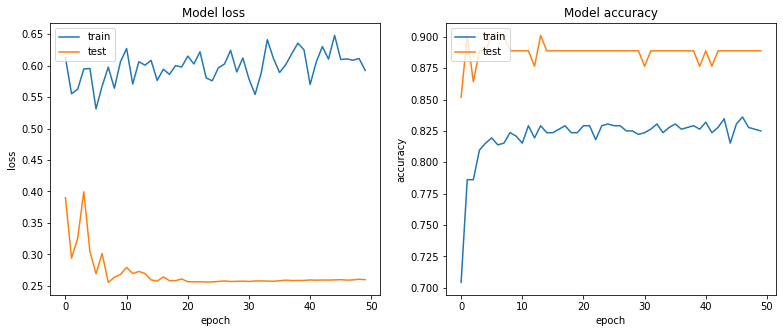

In [22]:
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [37]:
for index, item in enumerate(items_y) :
    # print("At index {} with the item {}".format(index, item[0]))
    result = int(round(model.predict(item)[0][0]))
    # print(result)
    subs.loc[(subs.index[index]), "Survived"] = result

In [38]:
subs.to_csv(submission_set, index=False, columns=['PassengerId', 'Survived'])

In [40]:
random_forest = RandomForestClassifier(n_estimators=120, max_depth=8)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print("Accuracy of the Random Forest classifier = {}%".format(acc_random_forest))

Accuracy of the Random Forest classifier = 87.14%


In [41]:
for index, item in enumerate(items_y) :
    # print("At index {} with the item {}".format(index, item[0]))
    result = random_forest.predict(item)[0]
    subs.loc[(subs.index[index]), "Survived"] = result

In [42]:
subs.to_csv(submission_set, index=False, columns=['PassengerId', 'Survived'])

In [43]:
def generate_random_submission(source_file_path="data/gender_submission.csv"):
    df = pd.read_csv(
        filepath_or_buffer=source_file_path,
        sep=",",
    )
    df["Survived"] = df["Survived"].apply(lambda x: random.choice([0, 1]))
    print(f"File data/my_submission.csv successfully generated.\n")
    df.to_csv("data/my_submission.csv", sep=",", index=False)
    
def submit_submission(competition_id="2357", submission_file="data/gender_submission.csv"):
    with open("kaggle.json") as credential:
        json_credential = json.loads(credential.read())
        os.environ["KAGGLE_USERNAME"] = json_credential["username"]
        os.environ["KAGGLE_KEY"] = json_credential["key"]
    result = subprocess.check_output(
        [
            "kaggle",
            "competitions",
            "submit",
            "titanic",
            "-f",
            submission_file,
            "-m",
            f"{dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}: New submission",
        ]
    ).decode("utf-8")
    print(result)

def get_latest_score(competition_id="2357", team_id="10059555"):
    with open("kaggle.json") as credential:
        json_credential = json.loads(credential.read())
        os.environ["KAGGLE_USERNAME"] = json_credential["username"]
        os.environ["KAGGLE_KEY"] = json_credential["key"]
        os.environ["KAGGLE_TEAM_ID"] = team_id
    result = subprocess.check_output(["kaggle", "competitions", "submissions", "titanic"]).decode("utf-8")
    print(result)
# generate_random_submission()
submit_submission()
get_latest_score()

Successfully submitted to Titanic - Machine Learning from Disaster
fileName               date                 description                                                                  status    publicScore  privateScore  
---------------------  -------------------  ---------------------------------------------------------------------------  --------  -----------  ------------  
gender_submission.csv  2023-08-23 19:41:45  2023-08-23 20:41:42: New submission                                          complete  0.77033                    
gender_submission.csv  2023-08-23 19:41:28  2023-08-23 20:41:25: New submission                                          complete  0.77272                    
gender_submission.csv  2023-08-23 19:40:45  2023-08-23 20:40:42: New submission                                          complete  0.77272                    
gender_submission.csv  2023-08-23 19:39:28  2023-08-23 20:39:25: New submission                                          complete  0.78229